# Fixing Blocked Obstruction Overlaps with RasFixit

This notebook demonstrates using the `RasFixit` module to automatically detect and repair overlapping blocked obstructions in HEC-RAS geometry files.

**Example Project:** HCFCD M3 Model A120-00-00 (Harris County Flood Control District)

In [1]:
# Uncomment to install/upgrade ras-commander from pip
#!pip install --upgrade ras-commander

import os
import sys
#Import the ras-commander package
from ras_commander import *

In [2]:
##### Optional Code Cell For Development/Testing Mode (Local Copy)
##### Uncomment and run this cell instead of the pip cell above

# For Development Mode, add the parent directory to the Python path
import os
import sys
from pathlib import Path

current_file = Path(os.getcwd()).resolve()
rascmdr_directory = current_file.parent

# Use insert(0) instead of append() to give highest priority to local version
if str(rascmdr_directory) not in sys.path:
    sys.path.insert(0, str(rascmdr_directory))

print("Loading ras-commander from local dev copy")
from ras_commander import *

## Overview

**Problem:** HEC-RAS geometry files sometimes contain overlapping or adjacent blocked obstructions, which cause model errors during geometry preprocessing.

**Solution:** `RasFixit.fix_blocked_obstructions()` automatically:
1. Detects overlapping/adjacent obstructions
2. Applies the elevation envelope algorithm (uses max elevation in overlap zones)
3. Inserts 0.02-unit gaps to prevent adjacency errors
4. Creates before/after PNG visualizations for engineering review
5. Creates timestamped backups

**Key Principle:** All fixes preserve hydraulic behavior by using the maximum (most restrictive) elevation in overlap zones.

## 1. Setup and Imports

In [3]:
# Standard imports
import sys
from pathlib import Path
import pandas as pd
import shutil

# Import RasFixit and related classes
from ras_commander import RasFixit, FixResults, FixMessage, FixAction
from ras_commander.fixit import log_parser

print("Imports successful!")
print(f"RasFixit: {RasFixit}")
print(f"FixAction values: {[e.value for e in FixAction]}")

Imports successful!
RasFixit: <class 'ras_commander.fixit.RasFixit.RasFixit'>
FixAction values: ['OVERLAP_RESOLVED', 'GAP_INSERTED', 'SEGMENT_MERGED', 'NO_ACTION']


In [4]:
# Path to example project (included in ras-commander)
# This is the HCFCD M3 Model A120-00-00 with known obstruction issues
examples_dir = Path(os.getcwd())
if examples_dir.name != 'examples':
    examples_dir = examples_dir / 'examples'

project_folder = examples_dir / "example_projects" / "A120-00-00"
geom_file = project_folder / "A120_00_00.g01"

print(f"Project folder: {project_folder}")
print(f"Geometry file exists: {geom_file.exists()}")

Project folder: c:\GH\ras-commander\examples\example_projects\A120-00-00
Geometry file exists: True


## 2. Detection: Find Overlapping Obstructions

First, let's detect overlapping obstructions without modifying any files. This is useful for:
- Pre-flight checks before running HEC-RAS
- Assessing the scope of issues in a geometry file
- Deciding whether to apply automatic fixes

In [5]:
# Detect overlaps without modifying the file
results = RasFixit.detect_obstruction_overlaps(geom_file)

print(f"Geometry File: {geom_file.name}")
print(f"Cross Sections Checked: {results.total_xs_checked}")
print(f"Cross Sections with Overlaps: {results.total_xs_fixed}")

if results.messages:
    print(f"\nAffected cross sections:")
    for msg in results.messages:
        print(f"  RS {msg.station}: {msg.original_count} obstructions -> would become {msg.fixed_count}")

Geometry File: A120_00_00.g01
Cross Sections Checked: 91
Cross Sections with Overlaps: 15

Affected cross sections:
  RS 20262.89: 5 obstructions -> would become 6
  RS 17853.49: 2 obstructions -> would become 2
  RS 17833.49: 2 obstructions -> would become 2
  RS 17612.53: 3 obstructions -> would become 3
  RS 15831.37: 2 obstructions -> would become 2
  RS 15136.2: 7 obstructions -> would become 8
  RS 14284.07: 3 obstructions -> would become 4
  RS 11422.31: 3 obstructions -> would become 4
  RS 11181.99: 3 obstructions -> would become 4
  RS 10150.51: 4 obstructions -> would become 5
  RS 10040.42: 4 obstructions -> would become 5
  RS 9960.36: 3 obstructions -> would become 4
  RS 5714.48: 2 obstructions -> would become 3
  RS 4894.121: 2 obstructions -> would become 2
  RS 4053.094: 2 obstructions -> would become 2


## 3. Examine the Overlapping Obstructions

Let's look at the detailed data for one of the affected cross sections.

In [6]:
# Look at first affected cross section in detail
if results.messages:
    msg = results.messages[0]
    
    print(f"=== Cross Section RS {msg.station} ===")
    print(f"\nOriginal Obstructions ({msg.original_count}):")
    for i, (start, end, elev) in enumerate(msg.original_data, 1):
        print(f"  {i}. Station {start:8.2f} to {end:8.2f}, Elevation: {elev:.2f}")
    
    print(f"\nFixed Obstructions ({msg.fixed_count}) - using max elevation envelope:")
    for i, (start, end, elev) in enumerate(msg.fixed_data, 1):
        print(f"  {i}. Station {start:8.2f} to {end:8.2f}, Elevation: {elev:.2f}")

=== Cross Section RS 20262.89 ===

Original Obstructions (5):
  1. Station  1771.46 to  2303.49, Elevation: 37.43
  2. Station  3165.57 to  4205.00, Elevation: 34.20
  3. Station  4825.70 to  5057.23, Elevation: 34.30
  4. Station  4850.00 to  5050.00, Elevation: 35.30
  5. Station  3100.00 to  3200.00, Elevation: 35.10

Fixed Obstructions (6) - using max elevation envelope:
  1. Station  1771.46 to  2303.49, Elevation: 37.43
  2. Station  3100.00 to  3200.00, Elevation: 35.10
  3. Station  3200.02 to  4205.00, Elevation: 34.20
  4. Station  4825.70 to  4850.00, Elevation: 34.30
  5. Station  4850.02 to  5050.00, Elevation: 35.30
  6. Station  5050.02 to  5057.23, Elevation: 34.30


## 4. Fix Overlapping Obstructions

Now let's apply the fixes. We'll work on a **copy** of the geometry file to preserve the original.

This will:
1. Create a timestamped backup of the file
2. Apply the elevation envelope algorithm to resolve overlaps
3. Generate before/after PNG visualizations
4. Return detailed results for engineering review

**IMPORTANT:** Always review the visualizations before accepting changes!

In [7]:
# Create a working copy so we don't modify the original
working_copy = project_folder / "A120_00_00_test_copy.g01"
shutil.copy(geom_file, working_copy)
print(f"Created working copy: {working_copy.name}")

# Fix overlapping obstructions with visualization
fix_results = RasFixit.fix_blocked_obstructions(
    working_copy,
    backup=True,       # Create timestamped backup
    visualize=True     # Generate before/after PNGs
)

print(f"\n=== Fix Results ===")
print(f"Cross Sections Checked: {fix_results.total_xs_checked}")
print(f"Cross Sections Fixed: {fix_results.total_xs_fixed}")
print(f"Backup Created: {fix_results.backup_path}")
print(f"Visualizations: {fix_results.visualization_folder}")

2025-12-13 20:15:08 - ras_commander.fixit.RasFixit - INFO - Created backup: c:\GH\ras-commander\examples\example_projects\A120-00-00\A120_00_00_test_copy.g01.backup_20251213_201508
2025-12-13 20:15:08 - ras_commander.fixit.RasFixit - INFO - Saving visualizations to: c:\GH\ras-commander\examples\example_projects\A120-00-00\A120_00_00_test_copy_g01_Obstructions_Fixed


Created working copy: A120_00_00_test_copy.g01


2025-12-13 20:15:12 - ras_commander.fixit.RasFixit - INFO - Fixed 15 cross sections in A120_00_00_test_copy.g01



=== Fix Results ===
Cross Sections Checked: 91
Cross Sections Fixed: 15
Backup Created: c:\GH\ras-commander\examples\example_projects\A120-00-00\A120_00_00_test_copy.g01.backup_20251213_201508
Visualizations: c:\GH\ras-commander\examples\example_projects\A120-00-00\A120_00_00_test_copy_g01_Obstructions_Fixed


## 5. Review Fix Results

The `FixResults` object contains detailed information about every fix applied. Let's examine it.

In [8]:
# Convert results to DataFrame for easy analysis
df = fix_results.to_dataframe()
print(f"Fix Summary DataFrame ({len(df)} rows):")
print(df[['station', 'action', 'original_count', 'fixed_count', 'message']].to_string())

Fix Summary DataFrame (15 rows):
     station            action  original_count  fixed_count                                                   message
0   20262.89  OVERLAP_RESOLVED               5            6  Resolved 5 overlapping obstructions to 6 non-overlapping
1   17853.49  OVERLAP_RESOLVED               2            2  Resolved 2 overlapping obstructions to 2 non-overlapping
2   17833.49  OVERLAP_RESOLVED               2            2  Resolved 2 overlapping obstructions to 2 non-overlapping
3   17612.53  OVERLAP_RESOLVED               3            3  Resolved 3 overlapping obstructions to 3 non-overlapping
4   15831.37  OVERLAP_RESOLVED               2            2  Resolved 2 overlapping obstructions to 2 non-overlapping
5    15136.2  OVERLAP_RESOLVED               7            8  Resolved 7 overlapping obstructions to 8 non-overlapping
6   14284.07  OVERLAP_RESOLVED               3            4  Resolved 3 overlapping obstructions to 4 non-overlapping
7   11422.31  OVERLAP_R

In [9]:
# Export to CSV for documentation
csv_path = project_folder / "obstruction_fix_report.csv"
df.to_csv(csv_path, index=False)
print(f"Fix report exported to: {csv_path}")

Fix report exported to: c:\GH\ras-commander\examples\example_projects\A120-00-00\obstruction_fix_report.csv


## 6. View Visualizations

The PNG visualizations show before/after comparisons for each fixed cross section. They are critical for engineering review.

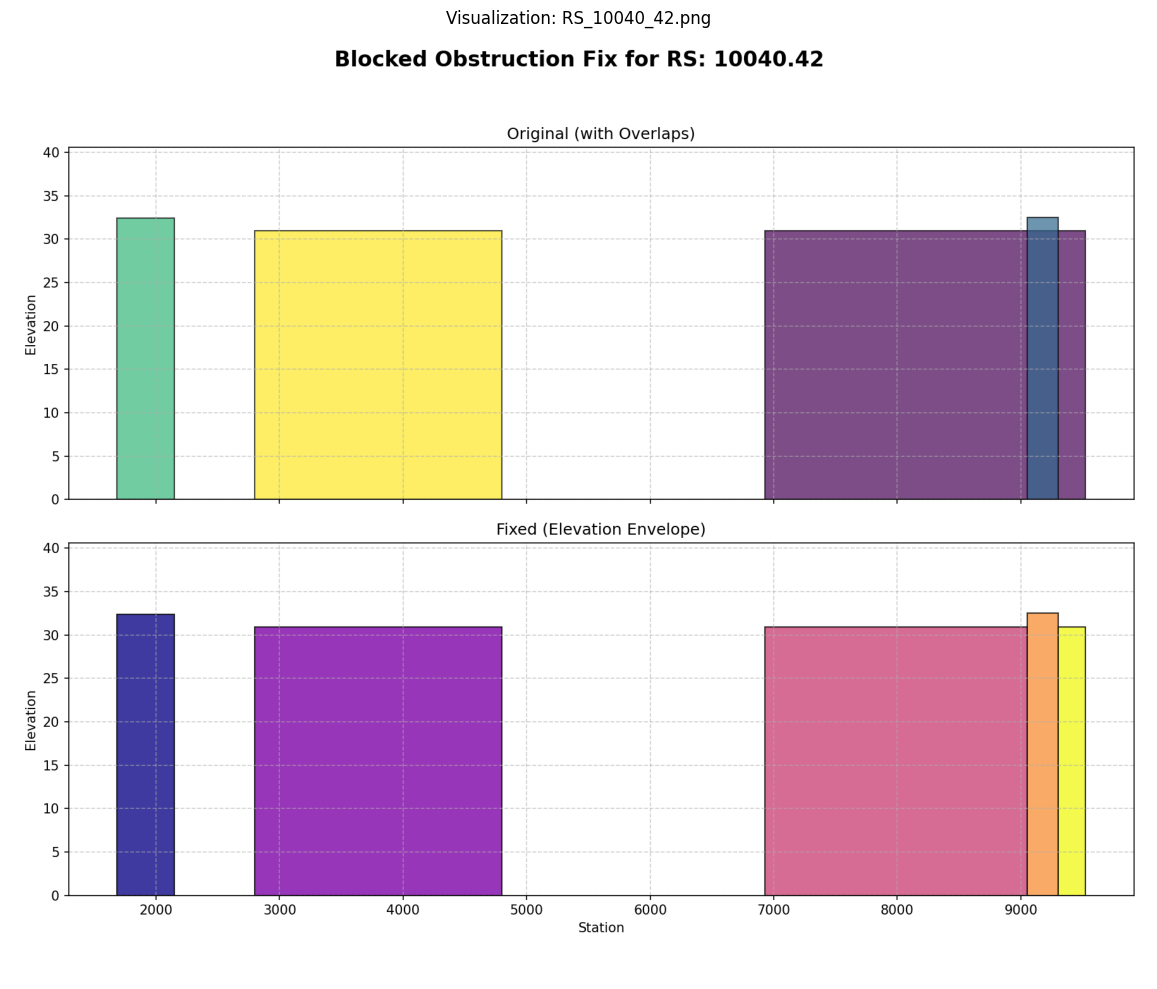


Total visualizations generated: 15
Location: c:\GH\ras-commander\examples\example_projects\A120-00-00\A120_00_00_test_copy_g01_Obstructions_Fixed


In [10]:
# Display a visualization (requires matplotlib)
import matplotlib.pyplot as plt
from matplotlib.image import imread

if fix_results.visualization_folder and fix_results.visualization_folder.exists():
    png_files = sorted(fix_results.visualization_folder.glob("*.png"))
    
    if png_files:
        # Display first visualization
        img = imread(png_files[0])
        plt.figure(figsize=(14, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Visualization: {png_files[0].name}")
        plt.tight_layout()
        plt.show()
        
        print(f"\nTotal visualizations generated: {len(png_files)}")
        print(f"Location: {fix_results.visualization_folder}")
    else:
        print("No PNG files found in visualization folder.")
else:
    print("No visualization folder available.")

In [11]:
# Display all visualizations (optional - may be slow for many cross sections)
show_all = False  # Set to True to view all

if show_all and fix_results.visualization_folder:
    png_files = sorted(fix_results.visualization_folder.glob("*.png"))
    
    for png_file in png_files:
        img = imread(png_file)
        plt.figure(figsize=(14, 10))
        plt.imshow(img)
        plt.axis('off')
        plt.title(png_file.name)
        plt.tight_layout()
        plt.show()

## 7. Verify Fixes

After fixing, verify that no overlaps remain.

In [12]:
# Verify no overlaps remain after fix
verify_results = RasFixit.detect_obstruction_overlaps(working_copy)

if verify_results.total_xs_fixed == 0:
    print("SUCCESS: No overlapping obstructions remaining!")
    print(f"Verified {verify_results.total_xs_checked} cross sections.")
else:
    print(f"WARNING: {verify_results.total_xs_fixed} cross sections still have overlaps.")
    print("Please review the file manually.")

SUCCESS: No overlapping obstructions remaining!
Verified 91 cross sections.


## 8. Log Parsing for Automated Workflows

The `log_parser` module can detect obstruction errors from HEC-RAS compute logs, enabling automated fix workflows.

In [13]:
# Example: Parse HEC-RAS log for obstruction errors
sample_log = """
HEC-RAS Model Computation
Processing cross section 20262.89
ERROR: Cross Section 20262.89 has overlapping blocked obstructions
Processing cross section 18765.43
ERROR: Blocked obstructions at station 18765.43 overlap or are adjacent
Computation complete with errors.
"""

# Detect errors
errors = log_parser.detect_obstruction_errors(sample_log)
print(f"Detected {len(errors)} obstruction errors")

# Extract affected stations
stations = log_parser.extract_cross_section_ids(sample_log)
print(f"Affected stations: {stations}")

# Generate human-readable report
print("\n" + log_parser.generate_error_report(errors))

Detected 2 obstruction errors
Affected stations: ['18765.43', '20262.89']

BLOCKED OBSTRUCTION ERROR REPORT

Total Errors Found: 2


OVERLAP (1 occurrences):
--------------------------------------------------------------------------------
  River Station: 20262.89
  Line: 4
  Message: ERROR: Cross Section 20262.89 has overlapping blocked obstructions


ADJACENT (1 occurrences):
--------------------------------------------------------------------------------
  River Station: 18765.43
  Line: 6
  Message: ERROR: Blocked obstructions at station 18765.43 overlap or are adjacent



In [14]:
# Automated workflow: Detect errors from log, then fix geometry files
def auto_fix_workflow(log_file_path, project_dir):
    """Automated workflow to detect and fix obstruction errors."""
    
    # Step 1: Check log for errors
    if not log_parser.has_obstruction_errors(log_file_path):
        print("No obstruction errors found in log.")
        return None
    
    # Step 2: Read log and detect errors
    with open(log_file_path, 'r') as f:
        log_content = f.read()
    
    errors = log_parser.detect_obstruction_errors(log_content)
    print(f"Found {len(errors)} obstruction errors")
    
    # Step 3: Find geometry files in project
    geom_files = log_parser.find_geometry_files_in_directory(project_dir)
    print(f"Found {len(geom_files)} geometry files")
    
    # Step 4: Fix each geometry file
    all_results = {}
    for geom_path in geom_files:
        results = RasFixit.fix_blocked_obstructions(
            geom_path,
            backup=True,
            visualize=True
        )
        all_results[geom_path] = results
        print(f"  Fixed {results.total_xs_fixed} cross sections in {Path(geom_path).name}")
    
    return all_results

print("auto_fix_workflow() function defined.")
print("Usage: auto_fix_workflow('compute.log', 'path/to/project')")

auto_fix_workflow() function defined.
Usage: auto_fix_workflow('compute.log', 'path/to/project')


## 9. Cleanup (Optional)

Remove test files after verification.

In [15]:
# Optional: Clean up test files
cleanup = True  # Set to False to keep test files

if cleanup:
    # Remove working copy
    if working_copy.exists():
        working_copy.unlink()
        print(f"Removed: {working_copy.name}")
    
    # Remove backup
    if fix_results.backup_path and fix_results.backup_path.exists():
        fix_results.backup_path.unlink()
        print(f"Removed backup: {fix_results.backup_path.name}")
    
    # Remove visualization folder
    if fix_results.visualization_folder and fix_results.visualization_folder.exists():
        shutil.rmtree(fix_results.visualization_folder)
        print(f"Removed visualization folder: {fix_results.visualization_folder.name}")
    
    # Remove CSV report
    if csv_path.exists():
        csv_path.unlink()
        print(f"Removed: {csv_path.name}")
    
    print("\nCleanup complete!")
else:
    print("Cleanup skipped. Set cleanup=True to remove test files.")

Removed: A120_00_00_test_copy.g01
Removed backup: A120_00_00_test_copy.g01.backup_20251213_201508
Removed visualization folder: A120_00_00_test_copy_g01_Obstructions_Fixed
Removed: obstruction_fix_report.csv

Cleanup complete!


## Summary

This notebook demonstrated:

**Detection:**
- `RasFixit.detect_obstruction_overlaps()` - Non-destructive scan for overlaps

**Fixing:**
- `RasFixit.fix_blocked_obstructions()` - Apply elevation envelope algorithm
  - `backup=True` creates timestamped backups
  - `visualize=True` generates before/after PNGs
  - `dry_run=True` detects without modifying

**Log Parsing:**
- `log_parser.detect_obstruction_errors()` - Parse HEC-RAS logs
- `log_parser.find_geometry_files_in_directory()` - Find .g## files
- `log_parser.generate_error_report()` - Human-readable report

**Results:**
- `FixResults.to_dataframe()` - Export to pandas DataFrame
- `FixMessage` contains original and fixed data for audit trail

### Engineering Review Requirements

**IMPORTANT:** All fixes should be reviewed by a licensed professional engineer before accepting changes to production models.

The visualization outputs provide an audit trail showing:
- Original obstruction configuration
- Fixed obstruction configuration
- Algorithm decisions made

### Algorithm Details

The elevation envelope algorithm:
1. Collects all critical stations (start/end of each obstruction)
2. For each segment between stations, uses **maximum elevation** (most restrictive)
3. Merges adjacent segments with same elevation
4. Inserts **0.02-unit gaps** where different elevations meet (HEC-RAS requirement)

This is **hydraulically conservative** - it preserves flow restrictions in overlap zones.

### Example Project

This notebook uses the HCFCD M3 Model A120-00-00 (Harris County Flood Control District), which contains real-world blocked obstruction issues in 15 of its 91 cross sections.